<a href="https://colab.research.google.com/github/Hami4214/EV-car-price-price-prediction-/blob/main/ev_price_prediction_updated_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from google.colab import files

# Load dataset

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Cheapestelectriccars-EVDatabase.csv")


# Function to clean numeric columns by removing non-numeric characters


In [4]:
def clean_numeric_column(column):
    return pd.to_numeric(df[column].astype(str).str.extract(r'(\d+\.?\d*)')[0], errors='coerce')

#Function to clean numeric columns by removing non-numeric characters

In [5]:
def clean_numeric_column(column):
    return pd.to_numeric(df[column].astype(str).str.extract(r'(\d+\.?\d*)')[0], errors='coerce')

# Columns to clean

In [6]:
numeric_columns = ["Acceleration", "TopSpeed", "Range", "Efficiency", "FastChargeSpeed", "PriceinGermany", "PriceinUK"]
for col in numeric_columns:
    df[col] = clean_numeric_column(col)

# Drop rows where both PriceinGermany & PriceinUK are missing

In [7]:
df_cleaned = df.dropna(subset=["PriceinGermany", "PriceinUK"], how="all")

# Convert UK Prices to Euros for consistency (assuming 1 GBP = 1.17 EUR)

In [32]:
df_cleaned = df_cleaned.copy()
df_cleaned["PriceinUK_EUR"] = df_cleaned["PriceinUK"] * 1.17


# Create a new DataFrame for visualization

In [12]:
df_price = df_cleaned[["PriceinGermany", "PriceinUK_EUR"]].dropna()
df_price = df_price.melt(var_name="Country", value_name="Price")
df_price["Country"] = df_price["Country"].replace({"PriceinGermany": "Germany", "PriceinUK_EUR": "UK (Converted to €)"})


#Price Distribution by Country

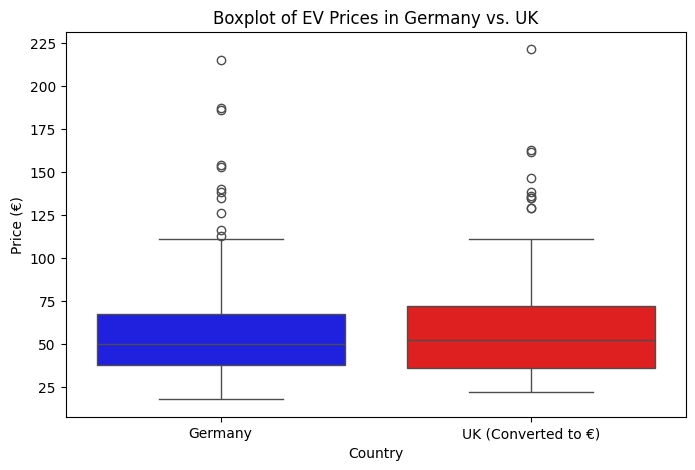

In [13]:
# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x="Country", y="Price", data=df_price, hue="Country", palette={"Germany": "blue", "UK (Converted to €)": "red"}, legend=False)
plt.title("Boxplot of EV Prices in Germany vs. UK")
plt.ylabel("Price (€)")
plt.show()

# Fill missing FastChargeSpeed values with median

In [14]:
df_cleaned.loc[:, "FastChargeSpeed"] = df_cleaned["FastChargeSpeed"].fillna(df_cleaned["FastChargeSpeed"].median())

# correlation matrix

In [15]:
correlation_matrix = df_cleaned[numeric_columns].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                 Acceleration  TopSpeed     Range  Efficiency  \
Acceleration         1.000000 -0.818290 -0.707780    0.156149   
TopSpeed            -0.818290  1.000000  0.756880   -0.059024   
Range               -0.707780  0.756880  1.000000   -0.083880   
Efficiency           0.156149 -0.059024 -0.083880    1.000000   
FastChargeSpeed     -0.671030  0.754924  0.708171   -0.107480   
PriceinGermany      -0.556683  0.752963  0.625618    0.244630   
PriceinUK           -0.665035  0.857522  0.688574    0.338822   

                 FastChargeSpeed  PriceinGermany  PriceinUK  
Acceleration           -0.671030       -0.556683  -0.665035  
TopSpeed                0.754924        0.752963   0.857522  
Range                   0.708171        0.625618   0.688574  
Efficiency             -0.107480        0.244630   0.338822  
FastChargeSpeed         1.000000        0.600074   0.650588  
PriceinGermany          0.600074        1.000000   0.984412  
PriceinUK               0

 # Correlation Heatmap

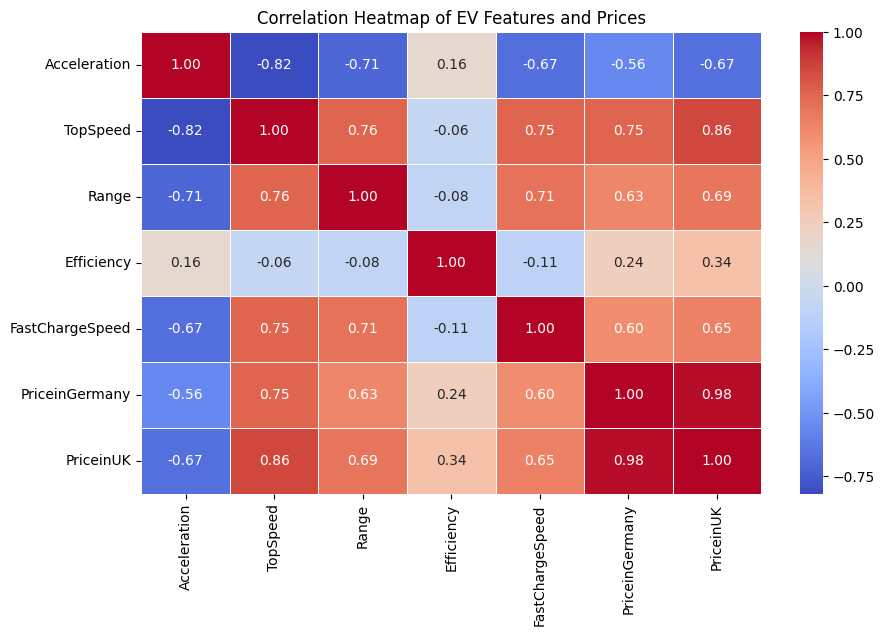

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned[numeric_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of EV Features and Prices")
plt.show()


# Define features and targets

In [17]:
features = ["Acceleration", "TopSpeed", "Range", "Efficiency", "FastChargeSpeed"]
target_germany = "PriceinGermany"
target_uk = "PriceinUK"

# Drop rows where PriceinUK is missing for UK model

In [18]:
df_uk = df_cleaned.dropna(subset=[target_uk])

# Split data for Germany

In [19]:
X_train_de, X_test_de, y_train_de, y_test_de = train_test_split(
    df_cleaned[features], df_cleaned[target_germany], test_size=0.2, random_state=42)

# Split data for UK

In [20]:
X_train_uk, X_test_uk, y_train_uk, y_test_uk = train_test_split(
    df_uk[features], df_uk[target_uk], test_size=0.2, random_state=42)

In [21]:
# Drop NaN values from target variables after splitting (test)
y_train_de = y_train_de.dropna()
y_test_de = y_test_de.dropna()

In [22]:
print(y_train_de.isna().sum(), y_test_de.isna().sum())

0 0


# Initialize models

In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42, loss="huber")
}

#test


In [24]:
print(X_train_de.shape, y_train_de.shape)

(141, 5) (134,)


In [25]:
# Drop rows with NaN values in both X_train_de and y_train_de
train_data_de = pd.concat([X_train_de, y_train_de], axis=1).dropna()
X_train_de = train_data_de[features]  # Extract features again
y_train_de = train_data_de[target_germany]  # Extract target again
print(X_train_de.shape, y_train_de.shape)

(134, 5) (134,)


#test

In [26]:
print(X_test_de.shape, y_test_de.shape)

(36, 5) (34,)


In [27]:
test_data_de = pd.concat([X_test_de, y_test_de], axis=1).dropna()
X_test_de = test_data_de[features]  # Extract features again
y_test_de = test_data_de[target_germany]  # Extract target again
print(X_test_de.shape, y_test_de.shape)

(34, 5) (34,)


# Function to train, predict and evaluate models

In [28]:
def train_and_evaluate(models, X_train, X_test, y_train, y_test, country):
    results = {}
    predictions = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        #debuging
        print(f"\n {name} Predictions ({country}) - Min Value BEFORE Fix: {y_pred.min()}")

        #  no negative prices are predicted
        y_pred = np.maximum(y_pred, 0)
        #debug min predicting value
        print(f"{name} Predictions ({country}) - Min Value AFTER Fix: {y_pred.min()}")
        predictions[name] = y_pred

        results[name] = {
            "R² Score": r2_score(y_test, y_pred),
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred)
        }
        print(f"\n{name} Performance ({country}):")
        print(f"R² Score: {results[name]['R² Score']:.3f}")
        print(f"MAE: {results[name]['MAE']:.2f}")
        print(f"RMSE: {results[name]['RMSE']:.2f}")

    return results, predictions

# Drop NaN values in PriceinGermany before splitting the data

In [33]:
df_cleaned = df_cleaned.dropna(subset=["PriceinGermany"])
print(df_cleaned["PriceinGermany"].isna().sum())

0


In [34]:
print(y_train_de.isna().sum(), y_test_de.isna().sum())

0 0


# Train and evaluate models for Germany

In [35]:
print("\n--- Predicting Prices in Germany ---")
results_germany, predictions_germany = train_and_evaluate(models, X_train_de, X_test_de, y_train_de, y_test_de, "Germany")


--- Predicting Prices in Germany ---

 Linear Regression Predictions (Germany) - Min Value BEFORE Fix: 13.005769986771071
Linear Regression Predictions (Germany) - Min Value AFTER Fix: 13.005769986771071

Linear Regression Performance (Germany):
R² Score: 0.476
MAE: 13.48
RMSE: 688.78

 Random Forest Predictions (Germany) - Min Value BEFORE Fix: 30.915
Random Forest Predictions (Germany) - Min Value AFTER Fix: 30.915

Random Forest Performance (Germany):
R² Score: 0.569
MAE: 11.72
RMSE: 566.55

 Gradient Boosting Predictions (Germany) - Min Value BEFORE Fix: 30.696874177551972
Gradient Boosting Predictions (Germany) - Min Value AFTER Fix: 30.696874177551972

Gradient Boosting Performance (Germany):
R² Score: 0.488
MAE: 13.23
RMSE: 673.07


# Train and evaluate models for UK

In [36]:
print("\n--- Predicting Prices in the UK ---")
results_uk, predictions_uk = train_and_evaluate(models, X_train_uk, X_test_uk, y_train_uk, y_test_uk, "UK")


--- Predicting Prices in the UK ---

 Linear Regression Predictions (UK) - Min Value BEFORE Fix: 21.076892858030106
Linear Regression Predictions (UK) - Min Value AFTER Fix: 21.076892858030106

Linear Regression Performance (UK):
R² Score: 0.872
MAE: 8.95
RMSE: 182.98

 Random Forest Predictions (UK) - Min Value BEFORE Fix: 27.79
Random Forest Predictions (UK) - Min Value AFTER Fix: 27.79

Random Forest Performance (UK):
R² Score: 0.752
MAE: 10.59
RMSE: 355.38

 Gradient Boosting Predictions (UK) - Min Value BEFORE Fix: 26.85241718390064
Gradient Boosting Predictions (UK) - Min Value AFTER Fix: 26.85241718390064

Gradient Boosting Performance (UK):
R² Score: 0.793
MAE: 9.71
RMSE: 296.90


#Residual Analysis for All Models

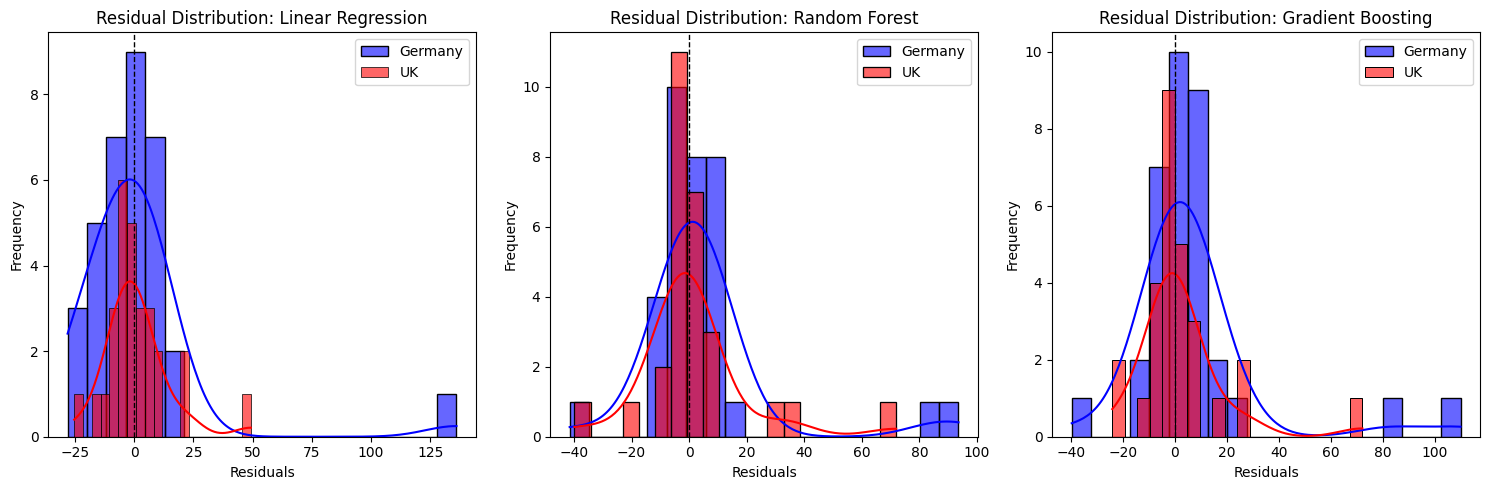

In [31]:
plt.figure(figsize=(15, 5))

for i, (name, model) in enumerate(models.items()):
    # Compute residuals for Germany
    residuals_germany = y_test_de - predictions_germany[name]

    # Compute residuals for UK
    residuals_uk = y_test_uk - predictions_uk[name]

    # Plot residual distribution
    plt.subplot(1, 3, i+1)
    sns.histplot(residuals_germany, kde=True, color="blue", label="Germany", alpha=0.6, bins=20)
    sns.histplot(residuals_uk, kde=True, color="red", label="UK", alpha=0.6, bins=20)

    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"Residual Distribution: {name}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

# Absolute Residuals

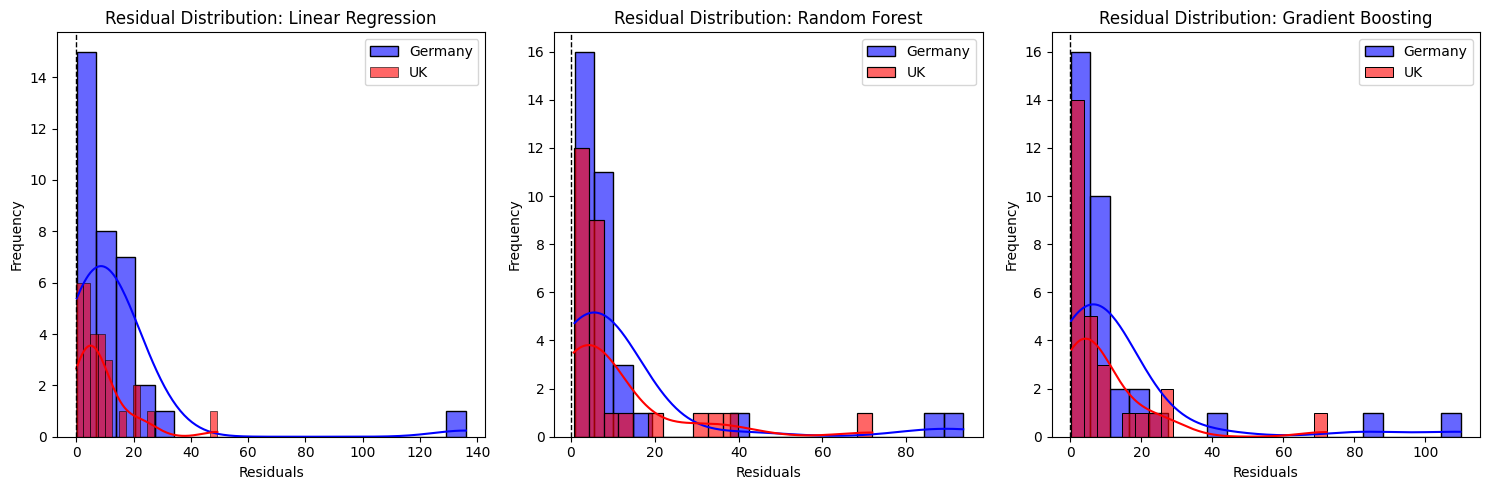

In [38]:
plt.figure(figsize=(15, 5))

for i, (name, model) in enumerate(models.items()):
    # Compute residuals for Germany (absolute residuals)
    residuals_germany = np.abs(y_test_de - predictions_germany[name])

    # Compute residuals for UK (absolute residuals)
    residuals_uk = np.abs(y_test_uk - predictions_uk[name])

    # Plot residual distribution
    plt.subplot(1, 3, i+1)
    sns.histplot(residuals_germany, kde=True, color="blue", label="Germany", alpha=0.6, bins=20)
    sns.histplot(residuals_uk, kde=True, color="red", label="UK", alpha=0.6, bins=20)

    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"Residual Distribution: {name}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()


#Residual Scatter Plot (Checking for Patterns)

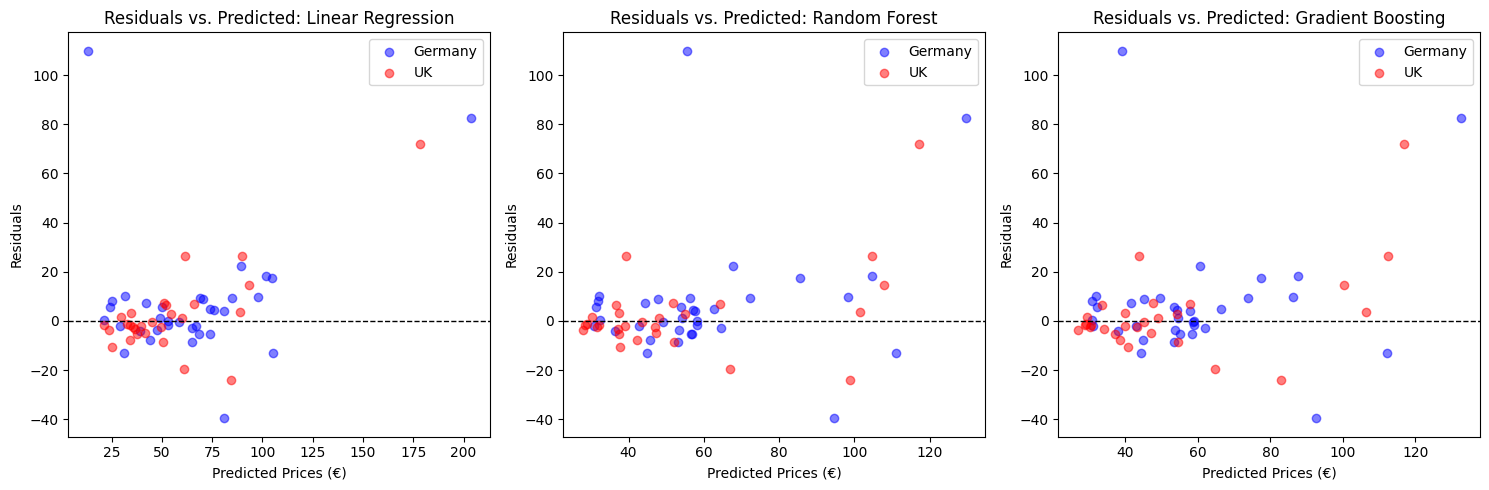

In [32]:
plt.figure(figsize=(15, 5))

for i, (name, model) in enumerate(models.items()):
    # Scatter plot for residuals in Germany
    plt.subplot(1, 3, i+1)
    plt.scatter(predictions_germany[name], residuals_germany, color="blue", alpha=0.5, label="Germany")
    plt.scatter(predictions_uk[name], residuals_uk, color="red", alpha=0.5, label="UK")

    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"Residuals vs. Predicted: {name}")
    plt.xlabel("Predicted Prices (€)")
    plt.ylabel("Residuals")
    plt.legend()

plt.tight_layout()
plt.show()

# Predicted Price Comparison (Germany vs. UK)

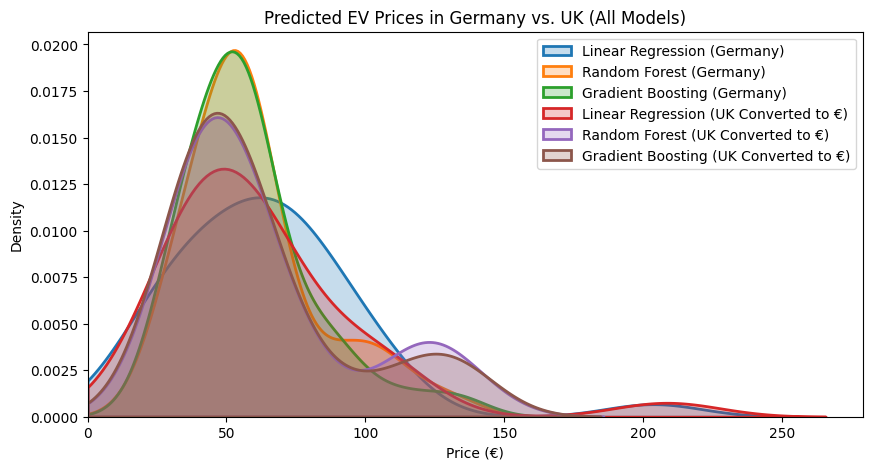

In [47]:
plt.figure(figsize=(10, 5))
for name, preds in predictions_germany.items():
    sns.kdeplot(preds, fill=True, label=f"{name} (Germany)", linewidth=2, clip=(0, None))  # 🔥 Ensures no negative prices

for name, preds in predictions_uk.items():
    sns.kdeplot(preds * 1.17, fill=True, label=f"{name} (UK Converted to €)", linewidth=2, clip=(0, None))  # 🔥 Clip negatives

plt.xlim(0, None)  # 🔥 Enforces non-negative prices
plt.title("Predicted EV Prices in Germany vs. UK (All Models)")
plt.xlabel("Price (€)")
plt.ylabel("Density")
plt.legend()
plt.show()


# Model Performance Comparison

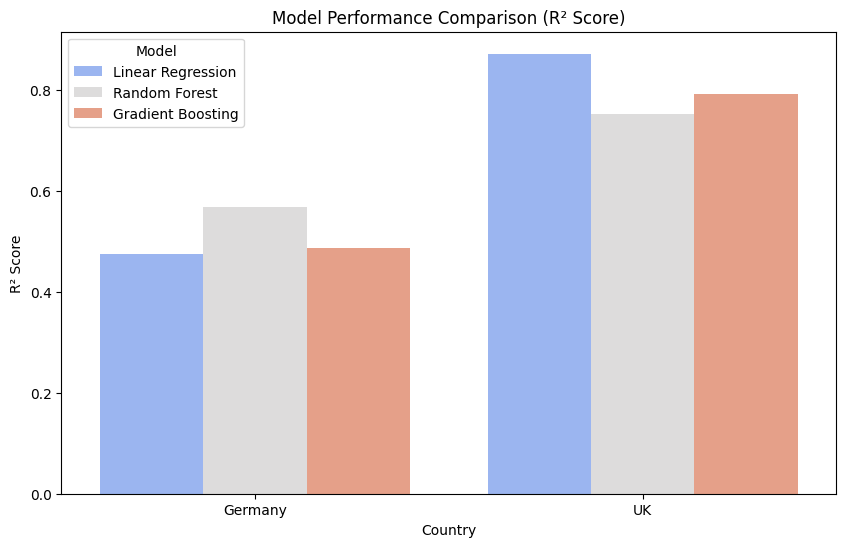

In [48]:
results_df = pd.DataFrame(results_germany).T
results_df["Country"] = "Germany"
results_uk_df = pd.DataFrame(results_uk).T
results_uk_df["Country"] = "UK"
results_combined = pd.concat([results_df, results_uk_df])

plt.figure(figsize=(10, 6))
sns.barplot(x="Country", y="R² Score", hue=results_combined.index, data=results_combined, palette="coolwarm")
plt.title("Model Performance Comparison (R² Score)")
plt.ylabel("R² Score")
plt.legend(title="Model")
plt.show()

# Price Distribution by Country

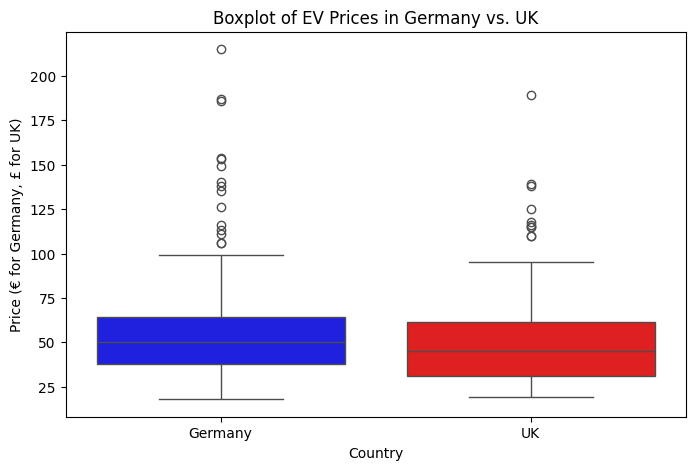

In [28]:
plt.figure(figsize=(8, 5))
df_cleaned_melted = df_cleaned.melt(value_vars=["PriceinGermany", "PriceinUK"], var_name="Country", value_name="Price")
df_cleaned_melted["Country"] = df_cleaned_melted["Country"].replace({"PriceinGermany": "Germany", "PriceinUK": "UK"})

sns.boxplot(x="Country", y="Price", data=df_cleaned_melted,hue="Country",  palette={"Germany": "blue", "UK": "red"})
plt.title("Boxplot of EV Prices in Germany vs. UK")
plt.ylabel("Price (€ for Germany, £ for UK)")
plt.show()